# Random Forest

In [18]:
import pandas as pd
import numpy as np
import json
import os
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import FeatureHasher
# from sklearn.model_selection import train_test_split
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)                    

In [2]:
path = os.getcwd()
path = path.replace("\\", "\\\\")
path = path.replace("\\\\", "/")
path_data = "/".join(path.split("/")[:-1]) + "/Data/"
path_est = path_data + "Estandarizada/"

In [3]:
df = pd.read_csv(path_est + "data_refined.csv", keep_default_na=False, na_values="", sep=',')
df['FECHA'] = pd.to_datetime(df.FECHA).dt.to_period('m')

In [4]:
#Crear un objeto FeatureHasher
fh = FeatureHasher(n_features=6, input_type='string')

#Transformar la variable categórica utilizando la codificación Hashing
hashed = fh.transform(df['PROVINCIA'])

#Convertir el resultado en un dataframe
hashed_df = pd.DataFrame(hashed.toarray())

#Unir el dataframe original con el dataframe de características codificadas
df = pd.concat([df, hashed_df], axis=1)
df = df.drop(columns=['PROVINCIA'])
df.rename(columns = {0:'HASH_0'}, inplace = True)
df.rename(columns = {1:'HASH_1'}, inplace = True)
df.rename(columns = {2:'HASH_2'}, inplace = True)
df.rename(columns = {3:'HASH_3'}, inplace = True)
df.rename(columns = {4:'HASH_4'}, inplace = True)
df.rename(columns = {5:'HASH_5'}, inplace = True)

In [5]:
df = df.assign(MONTH = lambda x: (x['FECHA'].astype(str).str.slice(start=5).astype(int)))

In [6]:
df

,FECHA,ALTITUD,TEMP_MED,PREC,DIR,VEL_MEDIA,RACHA,PRES_MIN,SOL,TASA_INCIDENCIA,HASH_0,HASH_1,HASH_2,HASH_3,HASH_4,HASH_5,MONTH
0,2020-01,58.0,11.519355,3.848387,23.580645,3.706452,12.183871,1013.903226,3.838710,0.09,0.0,0.0,1.0,-1.0,2.0,0.0,1
1,2020-01,674.0,6.996774,1.354839,32.483871,0.916129,6.451613,945.961290,5.474194,0.00,0.0,-1.0,-1.0,0.0,2.0,0.0,1
2,2020-01,81.0,11.664516,1.193548,22.000000,1.767742,7.741935,1013.180645,6.896774,0.00,1.0,-1.0,0.0,-1.0,2.0,-1.0,1
3,2020-01,21.0,12.487097,0.690323,53.967742,3.425806,9.629032,1020.690323,6.409677,0.00,1.0,0.0,0.0,1.0,3.0,0.0,1
4,2020-01,513.0,5.445161,0.948387,54.516129,3.229032,10.045161,963.483871,3.254839,0.00,0.0,0.0,-1.0,2.0,6.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,2023-02,690.0,5.757143,0.028571,19.892857,3.935714,11.978571,940.478571,7.700000,40.03,0.0,-1.0,1.0,0.0,2.0,0.0,2
1972,2023-02,56.0,9.582143,1.014286,59.678571,2.817857,8.164286,1015.625000,6.250000,24.16,1.0,0.0,0.0,0.0,2.0,-1.0,2
1973,2023-02,846.0,4.242857,0.267857,13.107143,3.760714,9.750000,924.460714,7.260714,78.59,1.0,0.0,2.0,-2.0,3.0,0.0,2
1974,2023-02,715.0,5.128571,0.335714,20.071429,1.757143,8.932143,939.407143,6.792857,183.92,0.0,0.0,0.0,1.0,4.0,1.0,2


In [7]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3)
df_train = df_train.reset_index()
df_test = df_test.reset_index()
df_train = df_train.drop(columns=["index"])
df_test = df_test.drop(columns=["index"])

In [8]:
df_train = df_train.set_index('FECHA')
df_test = df_test.set_index('FECHA')

In [9]:
df_train.reset_index(drop = True, inplace = True)

2
4
8
16
32
64
128
256


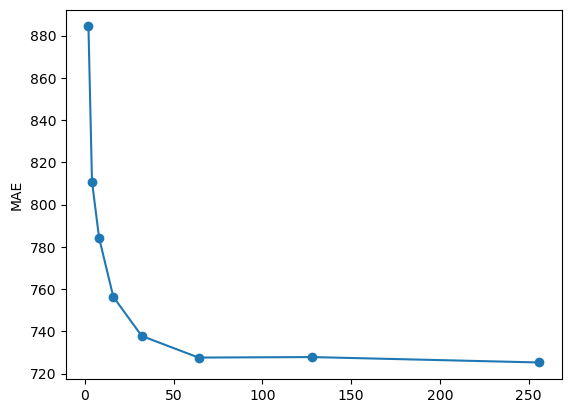

In [10]:
cv = TimeSeriesSplit()
l_estimators = [2, 4, 8, 16, 32, 64, 128, 256] #, 512, 1024]

total_scores = []
for estimators in l_estimators:
    print(estimators)
    fold_accuracy = []
    regressor =  RandomForestRegressor(n_estimators= estimators, criterion='absolute_error', random_state=0)
    for train_fold, test_fold in cv.split(df_train):
        #División train test aleatoria
        f_train = df_train.loc[train_fold]
        f_test = df_train.loc[test_fold]
        # entrenamiento y ejecución del modelo
        regressor.fit(X = f_train.drop(['TASA_INCIDENCIA'], axis=1), y = f_train['TASA_INCIDENCIA'])
        y_pred = regressor.predict(X = f_test.drop(['TASA_INCIDENCIA'], axis = 1))
        # evaluación del modelo
        mae = mean_absolute_error(f_test['TASA_INCIDENCIA'], y_pred)
        fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show() 

In [11]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 256, MAE = 725.25)


In [12]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error', 
                                   random_state=0)
# fit and predict

regressor.fit( X = df_train.drop(['TASA_INCIDENCIA'], axis=1), y = df_train['TASA_INCIDENCIA'])
y_pred = regressor.predict(X = df_test.drop(['TASA_INCIDENCIA'], axis = 1))

In [20]:
mse = mean_squared_error(
        y_true  = df_test['TASA_INCIDENCIA'],
        y_pred  = y_pred,
        squared = True
       )
rmse = mean_squared_error(
        y_true  = df_test['TASA_INCIDENCIA'],
        y_pred  = y_pred,
        squared = False
       )
mae = mean_absolute_error(df_test['TASA_INCIDENCIA'], y_pred)
r2 = r2_score(df_test['TASA_INCIDENCIA'], y_pred)

print("")
print(f"El error (mse) de test es: {mse}")
print("")
print(f"El error (rmse) de test es: {rmse}")
print("")
print(f"El error (mae) de test es: {mae}")
print("")
print(f"El error (r2) de test es: {r2}")


El error (mse) de test es: 1366850.1834222334

El error (rmse) de test es: 1169.123681832779

El error (mae) de test es: 689.7567344935709

El error (r2) de test es: 0.3388187971030142


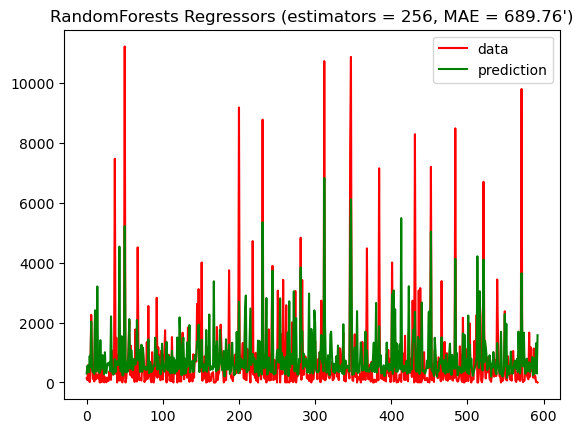

In [14]:
xx = np.stack(i for i in range(df_test['TASA_INCIDENCIA'].shape[0]))
plt.plot(xx, df_test['TASA_INCIDENCIA'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f')" % (best_est, mae))

plt.show()

In [15]:
regressor.feature_importances_

array([0.0370435 , 0.13851172, 0.11226919, 0.09650961, 0.08353015,
       0.10201503, 0.11670489, 0.11650269, 0.01860199, 0.01183366,
       0.01897089, 0.02906353, 0.02427205, 0.01744941, 0.0767217 ])

In [16]:
print ('Feature Relevancies')
pd.DataFrame({'Attributes': ('ALTITUD', 'TEMP_MED', 'PREC', 'DIR', 'VEL_MEDIA', 'RACHA', 'PRES_MIN', 'SOL', 
                             'HASH_0', 'HASH_1', 'HASH_2', 'HASH_3', 'HASH_4', 'HASH_5', 'MONTH') 
              ,'Decision Tree': regressor.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,ALTITUD,0.037044
1,TEMP_MED,0.138512
2,PREC,0.112269
3,DIR,0.096510
4,VEL_MEDIA,0.083530
5,RACHA,0.102015
6,PRES_MIN,0.116705
7,SOL,0.116503
8,HASH_0,0.018602
9,HASH_1,0.011834


# Mediante el Método de one hot encoding

In [ ]:
df_2 = pd.read_csv(path_est + "data_refined.csv", keep_default_na=False, na_values="", sep=',')
df_2['FECHA'] = pd.to_datetime(df_2.FECHA).dt.to_period('m')

In [ ]:
df_2

In [ ]:
oe_style = OneHotEncoder()

oe_results = oe_style.fit_transform(df_2[["PROVINCIA"]]) 
df_2 = df_2.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

df_2 = df_2.drop(columns=['PROVINCIA'])

In [ ]:
df_train_2, df_test_2 = train_test_split(df_2, test_size=0.3)
df_train_2 = df_train_2.reset_index()
df_test_2 = df_test_2.reset_index()
df_train_2 = df_train_2.drop(columns=["index"])
df_test_2 = df_test_2.drop(columns=["index"])

In [ ]:
df_train_2 = df_train_2.set_index('FECHA')
df_test_2 = df_test_2.set_index('FECHA')
df_train_2.reset_index(drop = True, inplace = True)
cv = TimeSeriesSplit()

In [ ]:
l_estimators = [2, 4, 8, 16, 32, 64, 128, 256] #, 512, 1024]

total_scores = []
for estimators in l_estimators:
    print(estimators)
    fold_accuracy = []
    regressor =  RandomForestRegressor(n_estimators= estimators, criterion='absolute_error', random_state=0)
    for train_fold, test_fold in cv.split(df_train_2):
        #División train test aleatoria
        f_train = df_train.loc[train_fold]
        f_test = df_train.loc[test_fold]
        # entrenamiento y ejecución del modelo
        regressor.fit(X = f_train.drop(['TASA_INCIDENCIA'], axis=1), y = f_train['TASA_INCIDENCIA'])
        y_pred = regressor.predict(X = f_test.drop(['TASA_INCIDENCIA'], axis = 1))
        # evaluación del modelo
        mae = mean_absolute_error(f_test['TASA_INCIDENCIA'], y_pred)
        fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show()

In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

In [ ]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error', 
                                   random_state=0)
# fit and predict

regressor.fit( X = df_train_2.drop(['TASA_INCIDENCIA'], axis=1), y = df_train_2['TASA_INCIDENCIA'])
y_pred = regressor.predict(X = df_test_2.drop(['TASA_INCIDENCIA'], axis = 1))

In [ ]:
mse = mean_squared_error(
        y_true  = df_test['TASA_INCIDENCIA'],
        y_pred  = y_pred,
        squared = True
       )
rmse = mean_squared_error(
        y_true  = df_test['TASA_INCIDENCIA'],
        y_pred  = y_pred,
        squared = False
       )
mae = mean_absolute_error(df_test['TASA_INCIDENCIA'], y_pred)
r2 = r2_score(df_test['TASA_INCIDENCIA'], y_pred)

print("")
print(f"El error (mse) de test es: {mse}")
print("")
print(f"El error (rmse) de test es: {rmse}")
print("")
print(f"El error (mae) de test es: {mae}")
print("")
print(f"El error (r2) de test es: {r2}")

In [ ]:
xx = np.stack(i for i in range(df_test_2['TASA_INCIDENCIA'].shape[0]))
plt.plot(xx, df_test_2['TASA_INCIDENCIA'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f')" % (best_est, mae))

plt.show()